# Sensitivity Analysis of SVM using DiffOpt.jl

- This notebook illustrates sensitivity analysis of data points in an SVM. 
- Inspired from http://github.com/matbesancon/SimpleSVMs.jl

For reference, Section 10.1 of https://online.stat.psu.edu/stat508/book/export/html/792 gives an intuitive explanation of what does it means to have a sensitive hyperplane or data point. The SVM is defined as:

$$
\begin{split}
\begin{array} {ll}
\mbox{minimize} & \sum_{i=1}^{N} \xi_{i} \\
\mbox{s.t.} & \xi_{i} \ge 0 \quad i=1..N  \\
            & y_{i} (w^T X_{i} + b) \ge 1 - \xi[i]\\
            & w^2 + b^2 \le penalty  \\
\end{array}
\end{split}
$$
where
- $X$, $y$ are the N data points
- $\xi$ is soft-margin loss
- regularization is achieved by adding a $penalty$ constraint

## Part 1: Define and solve theSVM

In [399]:
import Random
using Test
import SCS
import Plots
using DiffOpt
using MathOptInterface

const MOI = MathOptInterface;

In [400]:
Random.seed!(rand(1:100))
X = vcat(randn(30, 2), randn(30,2) .+ [4.0,1.5]')
y = append!(ones(30), -ones(30));

In [401]:
penalty = 5.0
(nobs, nfeat) = size(X)

model = diff_optimizer(SCS.Optimizer) 

# add variables
l = MOI.add_variables(model, nobs)
w = MOI.add_variables(model, nfeat)
b = MOI.add_variable(model)

t = MOI.add_variable(model)  # extra variable for the SOC constraint

MathOptInterface.VariableIndex(64)

In [402]:
MOI.add_constraint(
    model,
    MOI.VectorAffineFunction(
        MOI.VectorAffineTerm.(1:nobs, MOI.ScalarAffineTerm.(1.0, l)), zeros(nobs)
    ), 
    MOI.Nonnegatives(nobs)
)

MathOptInterface.ConstraintIndex{MathOptInterface.VectorAffineFunction{Float64},MathOptInterface.Nonnegatives}(1)

In [403]:
MOI.add_constraint(
    model,
    MOI.VectorAffineFunction([MOI.VectorAffineTerm(1, MOI.ScalarAffineTerm(-1.0, t))], [√penalty]),
    MOI.Zeros(1)
)

pen_const = MOI.add_constraint(
    model, 
    MOI.VectorAffineFunction(MOI.VectorAffineTerm.(1:(nfeat+2), MOI.ScalarAffineTerm.(1.0, vcat(t, w,b))), zeros(nfeat+2)), 
    MOI.SecondOrderCone(nfeat + 2)
)

MathOptInterface.ConstraintIndex{MathOptInterface.VectorAffineFunction{Float64},MathOptInterface.SecondOrderCone}(3)

In [404]:
# define the whole matrix Ax, it'll be easier then
# refer https://discourse.julialang.org/t/solve-minimization-problem-where-constraint-is-the-system-of-linear-inequation-with-mathoptinterface-efficiently/23571/4
Ax = Array{MOI.ScalarAffineTerm{Float64}}(undef, nobs, nfeat+2)
for i in 1:nobs
    Ax[i, :] = MOI.ScalarAffineTerm.([1.0; y[i]*X[i,:]; y[i]], [l[i]; w; b])
end
terms = MOI.VectorAffineTerm.(1:nobs, Ax)
f = MOI.VectorAffineFunction(
    vec(terms),
    -ones(nobs)
)
MOI.add_constraint(
    model,
    f,
    MOI.Nonnegatives(nobs)
)

MathOptInterface.ConstraintIndex{MathOptInterface.VectorAffineFunction{Float64},MathOptInterface.Nonnegatives}(4)

In [405]:
objective_function = MOI.ScalarAffineFunction(
                        MOI.ScalarAffineTerm.(ones(nobs), l),
                        0.0
                    )
MOI.set(model, MOI.ObjectiveFunction{MOI.ScalarQuadraticFunction{Float64}}(), objective_function)
MOI.set(model, MOI.ObjectiveSense(), MOI.MIN_SENSE)

MOI.optimize!(model);

loss = MOI.get(model, MOI.ObjectiveValue())
λ = MOI.get(model, MOI.ConstraintDual(), pen_const)[1]
wv = MOI.get(model, MOI.VariablePrimal(), w)
bv = MOI.get(model, MOI.VariablePrimal(), b)

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 305, CG tol ~ 1/iter^(2.00)
eps = 1.00e-005, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-003
Variables n = 64, constraints m = 125
Cones:	primal zero / dual free vars: 1
	linear vars: 120
	soc vars: 4, soc blks: 1
Setup time: 1.39e-004s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0|6.09e+019 1.84e+020 1.00e+000 -2.52e+021 2.63e+021 1.35e+021 6.81e-005 
   100|4.82e-005 1.51e-004 2.12e-004 1.96e+000 1.97e+000 1.83e-015 4.14e-003 
   140|3.50e-007 3.47e-006 1.18e-006 1

1.9417218747693665

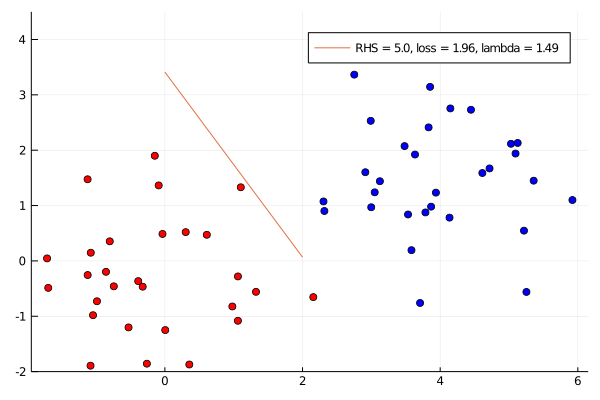

In [406]:
p = Plots.scatter(X[:,1], X[:,2], color = [yi > 0 ? :red : :blue for yi in y], label = "")
Plots.yaxis!(p, (-2, 4.5))
Plots.plot!(p, [0.0, 2.0], [-bv / wv[2], (-bv - 2wv[1])/wv[2]], label = "RHS = $(penalty), loss = $(round(loss, digits=2)), lambda = $(round(λ, digits=2))")

In [407]:
@test (wv'wv + bv*bv) ≈ penalty atol=1e-4  # sanity check

Test Passed

## Part 2: Differentiate wrt each data point

In [408]:
# x = model.primal_optimal
# s = MOI.get(model, MOI.ConstraintPrimal(), model.con_idx)
# dual = model.dual_optimal

dA = zeros(2*(nobs+nfeat) + 1, nobs+nfeat+1+1)
db = zeros(2*(nobs+nfeat) + 1)
dc = zeros(nobs+nfeat+1+1); # c = sum(`l`) + 0'w + 0.b + 0.t

# db[nobs+1] = 1.0   # only weighing the penalty constraint i.e. √penalty = t 
# dc[1] = 1.0

# dx, dy, ds = backward_conic!(model, dA, db, dc)

# dl, dw, db, dt = dx[1:50], dx[51:52], dx[53], dx[54]

In [409]:
∇ = []

# begin differentiating
for Xi in 1:nobs
    dA[nobs+5+Xi, nobs.+(1:2)] = ones(2) # set
    
    dx, dy, ds = backward_conic!(model, dA, db, dc)
    push!(∇, norm(dx) + norm(dy))
    
    dA[nobs+5+Xi, nobs.+(1:2)] = zeros(2)  # reset
end
∇ = normalize(∇);

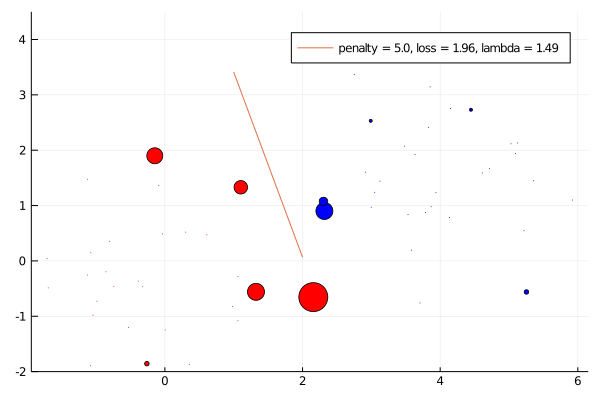

In [411]:
# point sensitvity wrt the separating hyperplane
# gradients are normalized

Plots.plot!(
    Plots.scatter(
        X[:,1], X[:,2], 
        color = [yi > 0 ? :red : :blue for yi in y], label = "",
        markersize= ∇ * 25
    ),
    ylims= (-2, 4.5),
    [-bv / wv[2],
    (-bv - 2wv[1])/wv[2]], label = "penalty = $(penalty), loss = $(round(loss, digits=2)), lambda = $(round(λ, digits=2))"
)

In [413]:
#Plots.heatmap(reshape(∇,1,length(∇)))